[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MobleyLab/drug-computing/blob/master/uci-pharmsci/assignments/MD/MD.ipynb)

# Molecular Dynamics (MD)

### Submission by AK Nandkeolyar

## Objective:
Perform some basic molecular dynamics (MD) simulations on a simple polymer model, perform some initial tests, and then after equilibrating the system, compute the self-diffusion coefficient for several different chain lengths. 

__Due date__: As assigned in class

## Overview:
One simple model of a polymer is just a chain of Lennard-Jones atoms. Here we will simulate such chains, interacting according to the potential (in dimensionless form): 

\begin{equation}
U^* = \sum \limits_{i<j \mathrm{,\  ij\  not\  bonded}} 4\left( r_{ij}^{-12} - r_{ij}^{-6}\right) + \sum \limits_{i<j\mathrm{,\  ij\  bonded}} \frac{k}{2} \left( r_{ij} - r_0\right)^2
\end{equation}

(Note that, as in the Energy Minimization assignment, we are using the dimensionless form, so that all of the constants are hidden in the units.)

Here, atoms have Lennard-Jones attractions and repulsions, and bonds between atoms along the polymer chain(s) are represented by simple harmonic springs. There are no torsional or angle potentials, and no electrostatic interactions. However, this simple model does share basic elements with the models we still use today for proteins and small molecules -- specifically, our classical MD models today begin with the potential above and add additional terms.
Simple systems like this polymer model have been thoroughly studied as models of polyatomic molecules, and as models of short polymers. It is relatively easy to derive or determine scaling laws for various physical properties as a function of polymer length in such systems. One such study, by Reis et al., [ Fluid Phase Equilibria 221: 25 (2004) ](https://doi.org/10.1016/j.fluid.2004.04.007) evaluated the self-diffusion coefficient for chains of different lengths. (The self-diffusion coefficient measures diffusive motion of something in a solution consisting of itself, for example the self-diffusion coefficient of water in water describes how mobile a water molecule is in pure water.)
Here, you will use some Python and Fortran libraries to set up some initial test simulations and make a plot relating to equilibration. Following that, you will compute the self-diffusion coefficient as directed below, making contact with the data of Reis et al. 

Most of the functions you will need have already been written for you and are provided here. Most of this assignment will involve using them to conduct a simulation. In addition to the paper mentioned, you will need `mdlib.f90` and `MD_functions.py`. As in the Energy Minimization assignment you did previously, you will need to compile `mdlib.f90` into a .so file suitable for use within Python.  

## Background/settings:
### Introduction of our variables:
Here, the potential energy will be as given above. Again, note that we are working in dimensionless form. 

We will simulate a system with a total of N monomers, some of which will be linked to form polymers. Each polymer will consist of M monomers, so that if $N_{poly}$ is the number of polymers, $N = M\times N_{poly}$. That is to say, we have $N_{poly}$ polymers each consisting of $M$ linked monomers in a chain, for a total of $N$ particles. 

As usual, our system will have a density, $\rho$, which is N/V. We will work with a particular temperature, $T$, and cutoff distance, $R_c$, beyond which Lennard-Jones interactions will not be included. Additionally, we need to specify a bond strength and equilibrium separation, $k$ and $r_0$, respectively. And we will take timesteps $\Delta t$ using the velocity Verlet integrator.

### Settings to use (unless otherwise noted)

Unless otherwise noted, here you should use the following settings:
* $k = 3000$ (spring constant)
* $r_0 = 1$ (preferred bond length)
* $N = 240$ (number of particles)
* $\rho = N/V = 0.8$ so that $L$, the box size, is $(N/\rho)^{1/3}$ 
* Use $L$ as the box size in your code
* $\Delta t = 0.001$ (timestep)
* $T = 1.0$ (temperature)
* $R_c = 2.5$ (call this Cut in your code)

Our use of the dimensionless form here includes setting all particle masses to 1. Because of this, forces and accelerations are the same thing. Additionally, units can be dropped, and the Boltzmann constant is equal to 1 in these units.


### What's provided

In this case, mdlib provides almost the same CalcEnergy and CalcEnergyForces routines you used in the previous assignment (for energy minimizations). Additionally, it provides a VVIntegrate function to actually use the integrator (Velocity Verlet) to take a timestep. You should look through the Fortran code to make sure you understand what is being done and see how it connects to what we covered in lecture.

The Python syntax for using VVintegrate looks like: 

`Pos, Vel, Accel, KEnergy, PEnergy = mdlib.vvintegrate( Pos, Vel, Accel, M, L, Cut, dt )` 

This takes a single timestep (covering time dt) and returns the position, velocity, acceleration, kinetic energy, and potential energy. 

Likewise, mdlib provides functions for calculating the potential energy, or the potential energy and forces, as:
`PEnergy = mdlib.calcenergy(Pos, M, L, Cut)`
and
`PE, Forces = mdlib.calcenergyforces(Pos, M, L, Cut, Forces)` 

By way of additional background/tips, Scott Shell has some very useful [simulation best practices](https://sites.engineering.ucsb.edu/~shell/che210d/Simulation_best_practices.pdf) tips which can help with thinking through how to code up and conduct effective simulations.

## Your assignment
All, or almost all, of the functions you will need to complete this assignment are described below. But before getting to the description, I want to explain the assignment. 

### Part A: Develop a simple molecular dynamics code and examine potential energy versus time for several values of M 
Edit the supplied code below (or MD.py if you prefer to work with the plain text; note that I have also provided MD_functions.py which is utilized by this notebook which provides only the functions you need and not a template for the code you need to write, since this is below) to develop a simple molecular dynamics code. Most of the functions you need are already provided (see documentation below, or in MD_functions.py). But, you do need to fill in the core of two functions:

* InitVelocities(N,T): Should take N, a number of particles and a target temperature and return a velocity array (‘Vel’) which is Nx3 with mean velocity corresponding to the correct average temperature. You may wish to do this by assigning random velocities and rescaling (see below).

* RescaleVelocities(Vel, T): Re-center the velocities to zero net momentum to remove any overall translational motion (i.e., subtract off the average velocity from all particles) and then re-scale the velocities to maintain the correct temperature. This can be done by noting that the average kinetic energy of the system is related in a simple way to the effective temperature: 

\begin{equation}
\frac{1}{2}\sum \limits_i m_i v_i^2 = \frac{3}{2} N k_B T
\end{equation}

The left-hand term is the kinetic energy, and here can be simplified by noting all of the masses in the system are defined to be 1. The right hand term involves the Boltzmann constant, the number of particles in the system, and the instantaneous temperature.

So, you can compute the effective temperature of your system, and translate this into a scaling factor which you can use to multiply (scale) all velocities in the system to ensure you get the correct average temperature (see http://www.pages.drexel.edu/~cfa22/msim/node33.html). **Specifically, following the Drexel page (eq. 177), compute a (scalar) constant by which you will multiply all of the velocities to ensure that the effective temperature is at the correct target value after rescaling.** To do this calculation you will need to compute the kinetic energy, which involves the sum above. 
    
Remove translational motion, rescale the velocities, and have your function return the  updated velocity array.
Once the above two functions are written, finishing write a simple MD code using the available functions to:
* Initially place atoms on a cubic lattice with the correct box size
* Energy-minimize the initial configuration using the conjugate-gradient energy minimizer; this will help ensure the simulation doesn’t “explode” (a highly technical term meaning “crash”) when you begin MD
* Assign initial velocities and compute forces (accelerations)
* Use the velocity Verlet integrator to perform a molecular dynamics run. Rescale atomic velocities every **RescaleFreq** integration steps to achieve the target temperature T. ( You can test whether you should rescale the velocities using the modulo (remainder) operator, for example $i % RescaleFreq == 0$)
   * You might want to use RescaleFreq = 100 (for extra credit, you can try several values of RescaleFreq and explain the differences in fluctuations in the potential energy versus time that you see)

Use the settings given above for $N$, $\rho$, $T$, the timestep, and the cutoff distance. 

Perform simulations for $M = 2, 4, 6, 8, 12,$ and $16$ and store the total energies versus time out to 2,000 timesteps. (Remember, $M$ controls the number of particles per polymer; you are keeping the same total number of particles in the system and changing the size of the polymers). On a single graph, plot the potential energy versus time for each of these cases (each in a different color). Turn in this graph.  

Note also you can visualize, if desired, using the Python module for writing to PDB files which you saw in the Energy Minimization exercise. 


### Part B: Extend your code to compute the self-diffusion coefficient as a function of chain length

Modify your MD code from above to perform a series of steps that will allow you to compute the self-diffusion coefficient as a function of chain length and determine how diffusion of polymers depends on the size of the polymer. To compute the self-diffusion coefficient, you will simply need to monitor the motion of each polymer in time. 

Here, you will first perform two equilibrations at constant temperature using velocity rescaling . The first will allow the system to reach the desired temperature and forget about its initial configuration (remember, it was started on a lattice). The second will allow you to compute the average total energy of the system. Then, you will fix the total energy at this value and perform a production simulation. 

Here’s what you should do:
* Following initial preparation (like above), first perform equilibration for NStepsEquil1 using velocity rescaling to target temperature T every RescaleFreq steps, using whatever value of RescaleFreq you used previously (NOT every step!)
* Perform a second equilibration for `NStepsEquil2` timesteps using velocity rescaling at the same frequency, storing energies while you do this. 
* Compute the average total energy over this second equilibration and rescale the velocities to start the final phase with the correct total energy. In other words, the total energy at the end of equilibration will be slightly above or below the average; you should find the kinetic energy you need to have to get the correct total energy, and rescale the velocities to get this kinetic energy. After this you will be doing no more velocity rescaling. (Hint: You can do this final rescaling easily by computing a scaling factor, and you will probably not be using the rescaling code you use to maintain the temperature during equilibration.)
* Copy the initial positions of the particles into a reference array for computing the mean squared displacement, for example using `Pos0 = Pos.copy()`
* Perform a production run for `NStepsProd` integration steps with constant energy (NVE) rather than velocity rescaling. Periodically record the time and mean squared displacement of the atoms from their initial positions. (You will need to write a small bit of code to compute mean squared displacements, but it shouldn’t take more than a couple of lines; you may send it to me to check if you are concerned about it). The mean squared displacement is given by 
\begin{equation}
\left<\left| \mathbf{r}-\mathbf{r_0} \right|^2 \right>
\end{equation}

  where the $\mathbf{r}$'s are the current and initial positions of the object in question so the mean squared   
  displacement measures the square of the distance traveled for the object. 

* Compute the self-diffusion coefficient, $D$. The mean squared displacement relates to the self-diffusion coefficient, $D$, in this way:
\begin{equation}
\left< \left| \mathbf{r} - \mathbf{r_0}\right| \right>^2 = 6 D t
\end{equation}

Here $D$ is the self-diffusion coefficient and t is the elapsed time. That is, the expected squared distance traveled (mean squared displacement) grows linearly with the elapsed time.

For settings, use NStepsEquil1 = 10,000 = NStepsEquil2 and NStepsProd = 100,000. (Note: You should probably do a “dry run” first with shorter simulations to ensure everything is working, as 100,000 steps might take an hour or more to run).

* Perform these runs for $M = 2, 4, 6, 8, 12,$ and $16$, storing results for each. 
* Plot the mean-squared displacement versus time for each M on the same graph. 
* Compute the diffusion coefficient for each $M$ from the slope of each graph and plot these fits on the same graph. You can do a linear least-squares fit easily in Numpy. 

`Slope, Intercept = np.polyfit( xvals, yvals, 1)`

Plot the diffusion coefficient versus $M$ and try and see if it follows any obvious scaling law. It should decrease with increasing $M$, but with what power? (You may want to refer to the Reis et al. paper). 

### What to turn in:
* Your plot of the potential energy versus time for each $M$ in Part A
* Mean-squared displacement versus time, and fit, for each $M$ in Part B, all on one plot
* The diffusion coefficient versus $M$ in Part B
* Your code for at least Part B
* Any comments you have - do you think you got it right? Why or why not? What was confusing/helpful? What would you do if you had more time? 
* Clearly label axes and curves on your plots!

You can send your comments/discussion as an e-mail, and the rest of the items as attachments.

### What’s provided for you: 
In this case, most of what you need is provided in the importable module `MD_functions.py` (which you can view with your favorite text editor, like `vi` or Atom), except for the functions for initial velocities and velocity rescaling -- in those cases, the shells are present below and you need to write the core (which will be very brief!).  **However, you will also need to insert the code for the `ConjugateGradient` function in `MD_functions.py`** from your work you did in the Energy Minimization assignment. If you did not do this, or did not get it correct (or if you are not certain if you did), you will need to e-mail David Mobley for solutions.

From the Fortran library `mdlib` (which you will compile as usual via `f2py3 -c -m mdlib mdlib.f90` or similar), the only new function you need is Velocity Verlet. In `MD_functions.py`, the following tools are available (this shows their documentation, not the details of the code, but you should only need to read the documentation in order to be able to use them. NOTE: No modification of these functions is needed; you only need to use them. You will only need to write `InitVelocities` and `RescaleVelocities` as described above, plus provide your previous code for `ConjugateGradient`: 


## Installing Packages

***If you are running this on Google Colab, please add the installation blocks from the [getting started notebook](https://github.com/MobleyLab/drug-computing/blob/master/uci-pharmsci/Getting_Started.ipynb) or [condacolab](https://github.com/aakankschit/drug-computing/blob/master/uci-pharmsci/Getting_Started_condacolab.ipynb) here and then execute the code below***


Help on module MD:

NAME

    MD - #MD exercise template for PharmSci 175/275


FUNCTIONS
    
    ConjugateGradient(Pos, dx, EFracTolLS, EFracTolCG, M, L, Cut)
        Performs a conjugate gradient search.
        Input:
            Pos: starting positions, (N,3) array
            dx: initial step amount
            EFracTolLS: fractional energy tolerance for line search
            EFracTolCG: fractional energy tolerance for conjugate gradient
            M: Monomers per polymer
            L: Box size
            Cut: Cutoff
        Output:
            PEnergy: value of potential energy at minimum
            Pos: minimum energy (N,3) position array

    InitPositions(N, L)
        Returns an array of initial positions of each atom,
        placed on a cubic lattice for convenience.
        Input:
            N: number of atoms
            L: box length
        Output:
            Pos: (N,3) array of positions

    InitVelocities(N, T)
        Returns an initial random velocity set.
        Input:
            N: number of atoms
            T: target temperature
        Output:
            Vel: (N,3) array of atomic velocities

        InstTemp(Vel)
        Returns the instantaneous temperature.
        Input:
            Vel: (N,3) array of atomic velocities
        Output:
            Tinst: float
    
    InstTemp(Vel):
       Returns the instantaneous temperature.
       Input:
           Vel: (N,3) array of atomic velocities
       Output:
           Tinst: float

    RescaleVelocities(Vel, T)
        Rescales velocities in the system to the target temperature.
        Input:
            Vel: (N,3) array of atomic velocities
            T: target temperature
        Output:
            Vel: same as above 
            
    LineSearch(Pos, Dir, dx, EFracTol, M, L, Cut, Accel=1.5, MaxInc=10.0,  
               MaxIter=10000)
        Performs a line search along direction Dir.
        Input:
            Pos: starting positions, (N,3) array
            Dir: (N,3) array of gradient direction
            dx: initial step amount
            EFracTol: fractional energy tolerance
            M: Monomers per polymer
            L: Box size
            Cut: Cutoff
            Accel: acceleration factor
            MaxInc: the maximum increase in energy for bracketing
            MaxIter: maximum number of iteration steps
        Output:
            PEnergy: value of potential energy at minimum along Dir
            Pos: minimum energy (N,3) position array along Dir



## Here, you should actually write your functions:

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import mdlib
import matplotlib.pyplot as plt
from MD_functions import *

In [2]:
def InitVelocities(N, T):
    """Returns an initial random velocity set. And rescales velocities using the RescaleVelocities function.
Input:
    N: number of atoms
    T: target temperature
Output:
    Vel: (N,3) array of atomic velocities
"""
    #WRITE THIS CODE
    Vel = np.random.random((N,3))
    #THEN RETURN THE NEW VELOCITIES
    return Vel


def RescaleVelocities(Vel, T):
    """Rescales velocities in the system to the target temperature.
Input:
    Vel: (N,3) numpy array of atomic velocities
    T: target temperature
Output:
    Vel: same as above
"""
    #WRITE THIS CODE
    #recenter to zero net momentum (assuming all masses same)
    #find the total kinetic energy
    #find velocity scale factor from ratios of kinetic energy
    #Update velocities
    #Vel_av = np.average(np.sqrt(np.sum(Vel**2,axis=0)))
    Vel_av = np.mean(Vel,axis=0)
    Vel = Vel-Vel_av
    Ti = InstTemp(Vel)
    scale_factor = np.sqrt(T/Ti)
    Vel = Vel*scale_factor

    #NOW RETURN THE NEW VELOCITIES
    return Vel

In [3]:
help(mdlib)

Help on module mdlib:

NAME
    mdlib

DESCRIPTION
    This module 'mdlib' is auto-generated with f2py (version:1.22.0).
    Functions:
        penergy = calcenergy(pos,m,l,rc,dim=shape(pos, 1),natom=shape(pos, 0))
        penergy,forces = calcenergyforces(pos,m,l,rc,forces,dim=shape(pos, 1),natom=shape(pos, 0))
        pos,vel,accel,kenergy,penergy = vvintegrate(pos,vel,accel,m,l,rc,dt,dim=shape(pos, 1),natom=shape(pos, 0))
    .

DATA
    __f2py_numpy_version__ = '1.22.0'
    calcenergy = <fortran object>
    calcenergyforces = <fortran object>
    vvintegrate = <fortran object>

VERSION
    1.22.0

FILE
    /Users/aakankschit/Desktop/Mobley Lab/drug-computing/uci-pharmsci/assignments/MD/mdlib.cpython-39-darwin.so




## Now use your functions, coupled with those provided, to code up your assignment:

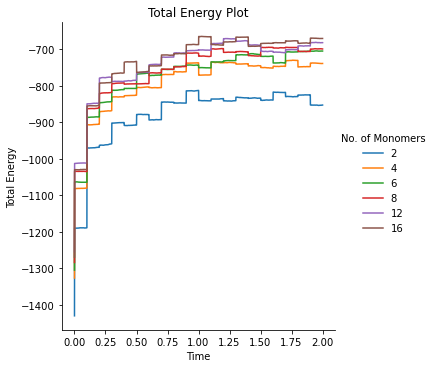

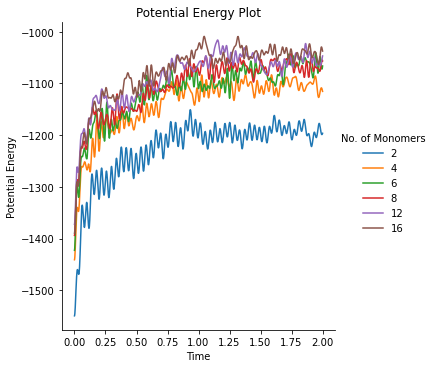

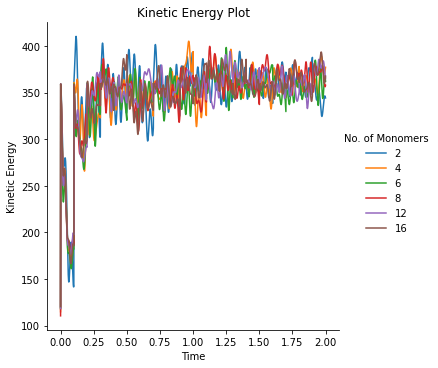

In [4]:
#PART A:

#Define box size and other settings
k=3000
r0=1
N=240
rho=0.8 #Solve to find L
L = (N/rho)**(1/3)
#Set L
dt=0.001
T=1.0
Cut=2.5
RescaleFreq = 100 #See note above - may want to try several values
EFracTolLS=10**-8
EFracTolCG=10**-10
#Define your M value(s)
M=[2,4,6,8,12,16]
#Initially place atoms on a cubic lattice
#Pos = InitPositions(N,L)
#Energy-minimize the initial configuration using the conjugate-gradient energy minimizer
#PE_min,Pos_min = ConjugateGradient(Pos,dt,EFracTolLS,EFracTolCG,M,L,Cut)
#Assign initial velocities and compute forces (accelerations)
forces = np.zeros((N,3))
time = np.linspace(0,dt*2000,2000)
#Use the velocity Verlet integrator to perform a molecular dynamics run, rescaling velocities when appropriate
complete_energy_df = pd.DataFrame(columns=("Time","No. of Monomers","Potential Energy","Kinetic Energy","Total Energy"))
Pos = InitPositions(N,L)
for monomers in M:
    PE_min,Pos_min = ConjugateGradient(Pos,dt,EFracTolLS,EFracTolCG,monomers,L,Cut)
    Vel = InitVelocities(N,T)
    PE,forces = mdlib.calcenergyforces(Pos_min,monomers,L,Cut,forces)
    accel = forces/N
    energy_df = pd.DataFrame(columns=("Time","No. of Monomers","Potential Energy","Kinetic Energy","Total Energy"))
    for n,t in enumerate(time):
        pos,Vel,accel,kenergy,penergy = mdlib.vvintegrate(Pos_min,Vel,forces,monomers,L,Cut,dt)
        energy_df.loc[n,"Time"] = t
        energy_df.loc[n,"No. of Monomers"] = monomers
        energy_df.loc[n,"Potential Energy"] = penergy
        energy_df.loc[n,"Kinetic Energy"] = kenergy
        energy_df.loc[n,"Total Energy"] = penergy+kenergy
        if n%RescaleFreq==0:
            Vel = RescaleVelocities(Vel,T)
        Pos_min=pos
        forces = accel
    complete_energy_df = pd.concat([complete_energy_df,energy_df])
complete_energy_df["No. of Monomers"] = complete_energy_df["No. of Monomers"].astype("category")
complete_energy_df.index = list(range(0,len(complete_energy_df)))
sns.relplot(x="Time", y="Total Energy", hue="No. of Monomers",kind="line", data=complete_energy_df).set(title = "Total Energy Plot")
sns.relplot(x="Time", y="Potential Energy", hue="No. of Monomers",kind="line", data=complete_energy_df).set(title = "Potential Energy Plot")
sns.relplot(x="Time", y="Kinetic Energy", hue="No. of Monomers",kind="line", data=complete_energy_df).set(title = "Kinetic Energy Plot")

## Part B

In [ ]:
NStepsEquil1 = 100
NStepsEquil2 = 100
NStepsProd = 1000
forces = np.zeros((N,3))
time_eq1 = np.linspace(0,dt*NStepsEquil1,NStepsEquil1)
time_eq2 = np.linspace(0,dt*NStepsEquil2,NStepsEquil2)
time_prod = np.linspace(0,dt*NStepsProd,NStepsProd)
complete_energy_df_prod = pd.DataFrame(columns=("Time","No. of Monomers","Potential Energy","Kinetic Energy","Total Energy"))
complete_MSD_df = pd.DataFrame(columns=("Time","No. of Monomers","MSD"))
diff_coeff = []
Pos = InitPositions(N,L)
for monomers in M:
    PE_min,Pos_min = ConjugateGradient(Pos,dt,EFracTolLS,EFracTolCG,monomers,L,Cut)
    Vel = InitVelocities(N,T)
    PE,forces = mdlib.calcenergyforces(Pos_min,monomers,L,Cut,forces)
    accel = forces/N
    for n1,t1 in enumerate(time_eq1):
        pos,Vel,accel,kenergy,penergy = mdlib.vvintegrate(Pos_min,Vel,forces,monomers,L,Cut,dt)
        if n%RescaleFreq==0:
            Vel = RescaleVelocities(Vel,T)
        Pos_min=pos
        forces = accel
    energy_df_eq2 = pd.DataFrame(columns=("Time","No. of Monomers","Potential Energy","Kinetic Energy","Total Energy"))
    for n2,t2 in enumerate(time_eq2):
        pos,Vel,accel,kenergy,penergy = mdlib.vvintegrate(Pos_min,Vel,forces,monomers,L,Cut,dt)
        energy_df_eq2.loc[n2,"Time"] = t2
        energy_df_eq2.loc[n2,"No. of Monomers"] = monomers
        energy_df_eq2.loc[n2,"Potential Energy"] = penergy
        energy_df_eq2.loc[n2,"Kinetic Energy"] = kenergy
        energy_df_eq2.loc[n2,"Total Energy"] = penergy+kenergy
        if n%RescaleFreq==0:
            Vel = RescaleVelocities(Vel,T)
        Pos_min=pos
        forces= accel
    TE_av = np.abs(np.mean(energy_df_eq2["Total Energy"]))
    delta = np.sqrt((2*TE_av)/np.sum(Vel**2))
    Vel = Vel*delta
    energy_df_prod = pd.DataFrame(columns=("Time","No. of Monomers","Potential Energy","Kinetic Energy","Total Energy"))
    MSD_df = pd.DataFrame(columns=("Time","No. of Monomers","MSD"))
    Pos0 = pos.copy()
    for n,t in enumerate(time_prod):
        pos,Vel,accel,kenergy,penergy = mdlib.vvintegrate(Pos_min,Vel,forces,monomers,L,Cut,dt)
        print(penergy+kenergy)
        energy_df_prod.loc[n,"Time"] = t
        energy_df_prod.loc[n,"No. of Monomers"] = monomers
        energy_df_prod.loc[n,"Potential Energy"] = penergy
        energy_df_prod.loc[n,"Kinetic Energy"] = kenergy
        energy_df_prod.loc[n,"Total Energy"] = penergy+kenergy
        Pos_min=pos
        forces= accel
        if n%10==0:
            MSD_df.loc[n/10,"Time"] = t
            MSD_df.loc[n/10,"No. of Monomers"] = monomers
            MSD_df.loc[n/10,"MSD"] = np.mean(np.abs(np.square(Pos_min-Pos0)))
    Slope, Intercept = np.polyfit( pd.to_numeric(MSD_df["Time"]), pd.to_numeric(MSD_df["MSD"]), 1)
    diff_coeff.append(Slope)
    complete_MSD_df = pd.concat([complete_MSD_df,MSD_df])
    complete_energy_df_prod = pd.concat([complete_energy_df_prod,energy_df_prod])
complete_energy_df_prod["No. of Monomers"] = complete_energy_df_prod["No. of Monomers"].astype("category")
complete_energy_df_prod.index = list(range(0,len(complete_energy_df_prod)))
complete_MSD_df["No. of Monomers"] = complete_MSD_df["No. of Monomers"].astype("category")
complete_MSD_df.index = list(range(0,len(complete_MSD_df)))
sns.relplot(x = "Time",y="MSD",hue = "No. of Monomers",kind="line",data=complete_MSD_df).set(title="MSD vs. Time Plot")

Text(0.5, 1.0, 'Diffusion Coefficient Plot')

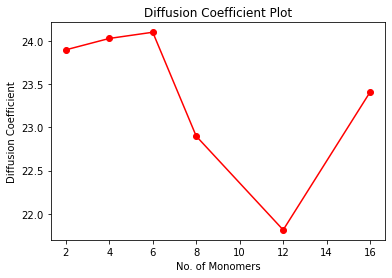

In [116]:
plt.plot(M,diff_coeff,'ro-')
plt.xlabel("No. of Monomers")
plt.ylabel("Diffusion Coefficient")
plt.title("Diffusion Coefficient Plot")

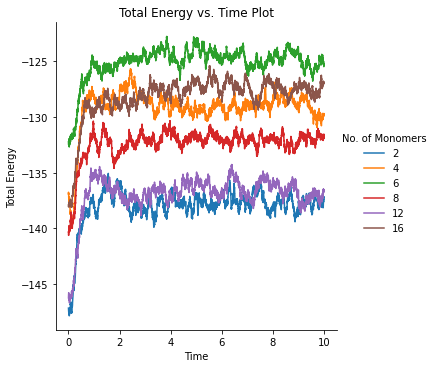

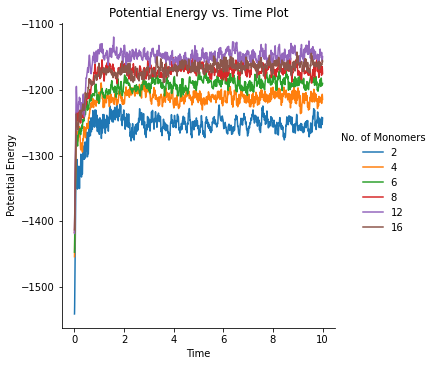

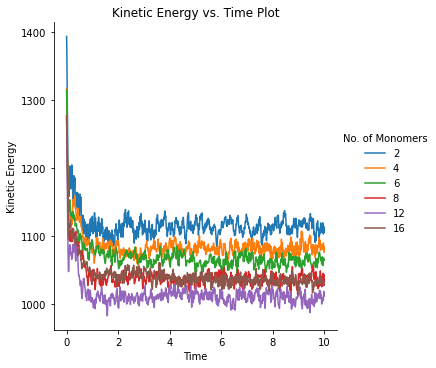

In [117]:
sns.relplot(x = "Time",y="Total Energy",hue = "No. of Monomers",kind="line",data=complete_energy_df_prod).set(title="Total Energy vs. Time Plot")
sns.relplot(x = "Time",y="Potential Energy",hue = "No. of Monomers",kind="line",data=complete_energy_df_prod).set(title="Potential Energy vs. Time Plot")
sns.relplot(x = "Time",y="Kinetic Energy",hue = "No. of Monomers",kind="line",data=complete_energy_df_prod).set(title="Kinetic Energy vs. Time Plot")

### Part B - Attempt 2

Based on recommendations by instructor

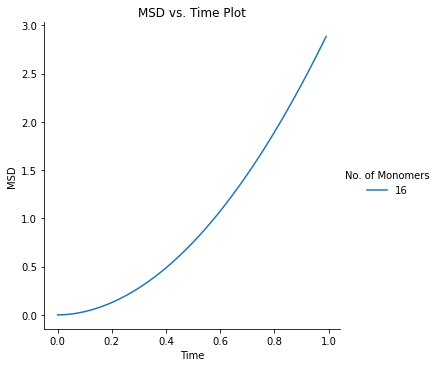

In [ ]:
NStepsEquil1 = 100
NStepsEquil2 = 100
NStepsProd = 1000
MSD_Sampling = 10
forces = np.zeros((N,3))
time_eq1 = np.linspace(0,dt*NStepsEquil1,NStepsEquil1)
time_eq2 = np.linspace(0,dt*NStepsEquil2,NStepsEquil2)
time_prod = np.linspace(0,dt*NStepsProd,NStepsProd)
Pos = InitPositions(N,L)
# Initialize Dataframes 
energy_eq_df = pd.DataFrame(index=list(range(NStepsEquil2)),columns=("Time","No. of Monomers","Total Energy"))
energy_df_prod= pd.DataFrame(index=list(range(NStepsProd)),columns=("Time","No. of Monomers","Potential Energy","Kinetic Energy","Total Energy"))
MSD_df = pd.DataFrame(index=list(range(int(NStepsProd/MSD_Sampling))),columns=("Time","No. of Monomers","MSD"))
diff_coeff = []
for mn,monomers in enumerate(M):
    PE_min,Pos_min = ConjugateGradient(Pos,dt,EFracTolLS,EFracTolCG,monomers,L,Cut)
    Vel = InitVelocities(N,T)
    PE,accel = mdlib.calcenergyforces(Pos_min,monomers,L,Cut,forces)
    Pos = Pos_min
    for n1,t1 in enumerate(time_eq1):
        Pos,Vel,accel,kenergy,penergy = mdlib.vvintegrate(Pos,Vel,accel,monomers,L,Cut,dt)
        if n%RescaleFreq==0:
            Vel = RescaleVelocities(Vel,T)
    for n2,t2 in enumerate(time_eq2):
        Pos,Vel,accel,kenergy,penergy = mdlib.vvintegrate(Pos,Vel,accel,monomers,L,Cut,dt)
        energy_eq_df.loc[mn*NStepsEquil2+n2,"Time"] = t2
        energy_eq_df.loc[mn*NStepsEquil2+n2,"No. of Monomers"] = monomers
        energy_eq_df.loc[mn*NStepsEquil2+n2,"Total Energy"] = penergy+kenergy
        if n%RescaleFreq==0:
            Vel = RescaleVelocities(Vel,T)
    TE_av = np.abs(np.mean(energy_eq_df["Total Energy"]))
    delta = np.sqrt((2*TE_av)/np.sum(Vel**2))
    Vel = Vel*delta
    Pos0 = Pos.copy()
    for n,t in enumerate(time_prod):
        Pos,Vel,accel,kenergy,penergy = mdlib.vvintegrate(Pos,Vel,accel,monomers,L,Cut,dt)
        energy_df_prod.loc[mn*NStepsProd+n,"Time"] = t
        energy_df_prod.loc[mn*NStepsProd+n,"No. of Monomers"] = monomers
        energy_df_prod.loc[mn*NStepsProd+n,"Potential Energy"] = penergy
        energy_df_prod.loc[mn*NStepsProd+n,"Kinetic Energy"] = kenergy
        energy_df_prod.loc[mn*NStepsProd+n,"Total Energy"] = penergy+kenergy
        if n%MSD_Sampling==0:
            MSD_df.loc[n/MSD_Sampling,"Time"] = t
            MSD_df.loc[n/MSD_Sampling,"No. of Monomers"] = monomers
            MSD_df.loc[n/MSD_Sampling,"MSD"] = np.mean(np.abs(np.square(Pos-Pos0)))
    Slope, Intercept = np.polyfit( pd.to_numeric(MSD_df["Time"]), pd.to_numeric(MSD_df["MSD"]), 1)
    diff_coeff.append(Slope)
energy_df_prod["No. of Monomers"] = energy_df_prod["No. of Monomers"].astype("category") 
energy_df_prod.index = list(range(0,len(energy_df_prod)))
MSD_df["No. of Monomers"] = MSD_df["No. of Monomers"].astype("category")
MSD_df.index = list(range(0,len(MSD_df)))
sns.relplot(x = "Time",y="MSD",hue = "No. of Monomers",kind="line",data=MSD_df).set(title="MSD vs. Time Plot")       

Text(0.5, 1.0, 'Diffusion Coefficient Plot')

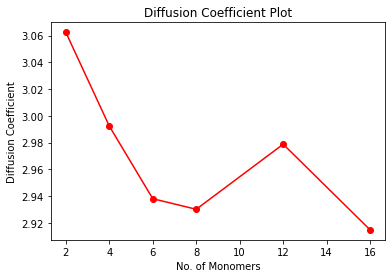

In [10]:
plt.plot(M,diff_coeff,'ro-')
plt.xlabel("No. of Monomers")
plt.ylabel("Diffusion Coefficient")
plt.title("Diffusion Coefficient Plot")

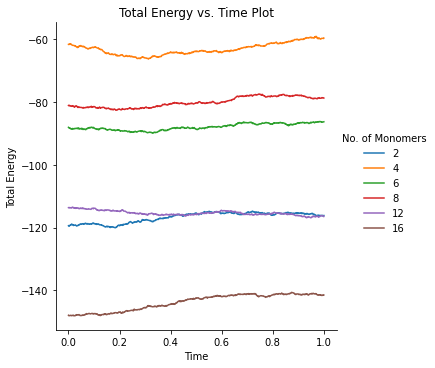

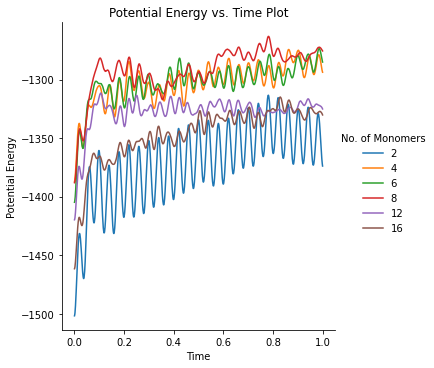

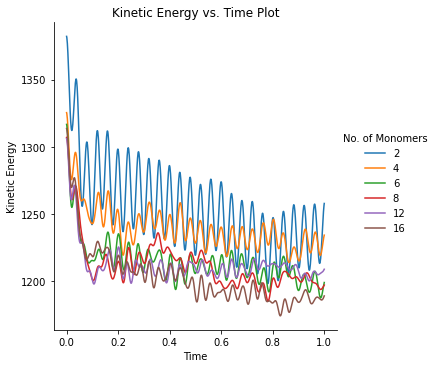

In [11]:
sns.relplot(x = "Time",y="Total Energy",hue = "No. of Monomers",kind="line",data=energy_df_prod).set(title="Total Energy vs. Time Plot")
sns.relplot(x = "Time",y="Potential Energy",hue = "No. of Monomers",kind="line",data=energy_df_prod).set(title="Potential Energy vs. Time Plot")
sns.relplot(x = "Time",y="Kinetic Energy",hue = "No. of Monomers",kind="line",data=energy_df_prod).set(title="Kinetic Energy vs. Time Plot")

## Extra Credit 

### Rescale Frequency of 10

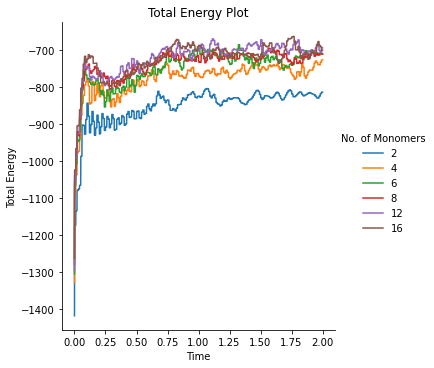

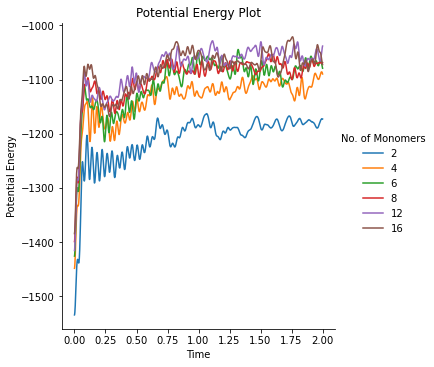

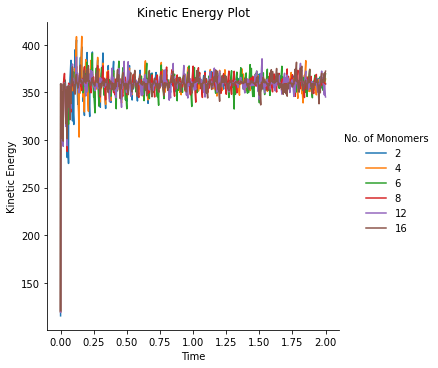

In [48]:
#PART A:

#Define box size and other settings
k=3000
r0=1
N=240
rho=0.8 #Solve to find L
L = (N/rho)**(1/3)
#Set L
dt=0.001
T=1.0
Cut=2.5
RescaleFreq = 10 #See note above - may want to try several values
EFracTolLS=10**-8
EFracTolCG=10**-10
#Define your M value(s)
M=[2,4,6,8,12,16]
#Initially place atoms on a cubic lattice
#Pos = InitPositions(N,L)
#Energy-minimize the initial configuration using the conjugate-gradient energy minimizer
#PE_min,Pos_min = ConjugateGradient(Pos,dt,EFracTolLS,EFracTolCG,M,L,Cut)
#Assign initial velocities and compute forces (accelerations)
forces = np.zeros((N,3))
time = np.linspace(0,dt*2000,2000)
#Use the velocity Verlet integrator to perform a molecular dynamics run, rescaling velocities when appropriate
complete_energy_df = pd.DataFrame(columns=("Time","No. of Monomers","Potential Energy","Kinetic Energy","Total Energy"))
Pos = InitPositions(N,L)
for monomers in M:
    PE_min,Pos_min = ConjugateGradient(Pos,dt,EFracTolLS,EFracTolCG,monomers,L,Cut)
    Vel = InitVelocities(N,T)
    PE,forces = mdlib.calcenergyforces(Pos_min,monomers,L,Cut,forces)
    accel = forces/N
    energy_df = pd.DataFrame(columns=("Time","No. of Monomers","Potential Energy","Kinetic Energy","Total Energy"))
    for n,t in enumerate(time):
        pos,Vel,accel,kenergy,penergy = mdlib.vvintegrate(Pos_min,Vel,forces,monomers,L,Cut,dt)
        energy_df.loc[n,"Time"] = t
        energy_df.loc[n,"No. of Monomers"] = monomers
        energy_df.loc[n,"Potential Energy"] = penergy
        energy_df.loc[n,"Kinetic Energy"] = kenergy
        energy_df.loc[n,"Total Energy"] = penergy+kenergy
        if n%RescaleFreq==0:
            Vel = RescaleVelocities(Vel,T)
        Pos_min=pos
        forces = accel
    complete_energy_df = pd.concat([complete_energy_df,energy_df])
complete_energy_df["No. of Monomers"] = complete_energy_df["No. of Monomers"].astype("category")
complete_energy_df.index = list(range(0,len(complete_energy_df)))
sns.relplot(x="Time", y="Total Energy", hue="No. of Monomers",kind="line", data=complete_energy_df).set(title = "Total Energy Plot")
sns.relplot(x="Time", y="Potential Energy", hue="No. of Monomers",kind="line", data=complete_energy_df).set(title = "Potential Energy Plot")
sns.relplot(x="Time", y="Kinetic Energy", hue="No. of Monomers",kind="line", data=complete_energy_df).set(title = "Kinetic Energy Plot")

### Rescale Frequency of 200

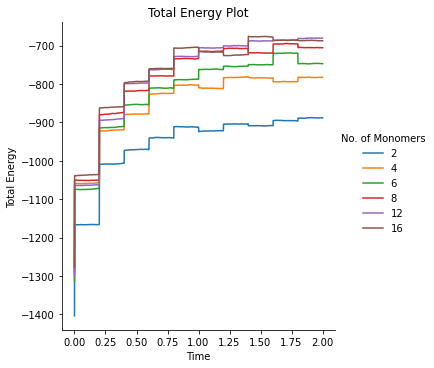

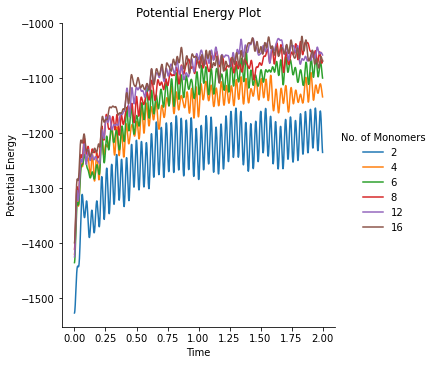

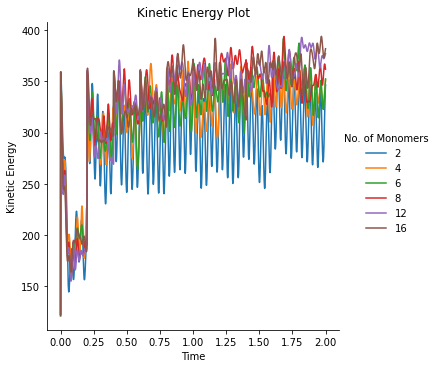

In [49]:
#PART A:

#Define box size and other settings
k=3000
r0=1
N=240
rho=0.8 #Solve to find L
L = (N/rho)**(1/3)
#Set L
dt=0.001
T=1.0
Cut=2.5
RescaleFreq = 200 #See note above - may want to try several values
EFracTolLS=10**-8
EFracTolCG=10**-10
#Define your M value(s)
M=[2,4,6,8,12,16]
#Initially place atoms on a cubic lattice
#Pos = InitPositions(N,L)
#Energy-minimize the initial configuration using the conjugate-gradient energy minimizer
#PE_min,Pos_min = ConjugateGradient(Pos,dt,EFracTolLS,EFracTolCG,M,L,Cut)
#Assign initial velocities and compute forces (accelerations)
forces = np.zeros((N,3))
time = np.linspace(0,dt*2000,2000)
#Use the velocity Verlet integrator to perform a molecular dynamics run, rescaling velocities when appropriate
complete_energy_df = pd.DataFrame(columns=("Time","No. of Monomers","Potential Energy","Kinetic Energy","Total Energy"))
Pos = InitPositions(N,L)
for monomers in M:
    PE_min,Pos_min = ConjugateGradient(Pos,dt,EFracTolLS,EFracTolCG,monomers,L,Cut)
    Vel = InitVelocities(N,T)
    PE,forces = mdlib.calcenergyforces(Pos_min,monomers,L,Cut,forces)
    accel = forces/N
    energy_df = pd.DataFrame(columns=("Time","No. of Monomers","Potential Energy","Kinetic Energy","Total Energy"))
    for n,t in enumerate(time):
        pos,Vel,accel,kenergy,penergy = mdlib.vvintegrate(Pos_min,Vel,forces,monomers,L,Cut,dt)
        energy_df.loc[n,"Time"] = t
        energy_df.loc[n,"No. of Monomers"] = monomers
        energy_df.loc[n,"Potential Energy"] = penergy
        energy_df.loc[n,"Kinetic Energy"] = kenergy
        energy_df.loc[n,"Total Energy"] = penergy+kenergy
        if n%RescaleFreq==0:
            Vel = RescaleVelocities(Vel,T)
        Pos_min=pos
        forces = accel
    complete_energy_df = pd.concat([complete_energy_df,energy_df])
complete_energy_df["No. of Monomers"] = complete_energy_df["No. of Monomers"].astype("category")
complete_energy_df.index = list(range(0,len(complete_energy_df)))
sns.relplot(x="Time", y="Total Energy", hue="No. of Monomers",kind="line", data=complete_energy_df).set(title = "Total Energy Plot")
sns.relplot(x="Time", y="Potential Energy", hue="No. of Monomers",kind="line", data=complete_energy_df).set(title = "Potential Energy Plot")
sns.relplot(x="Time", y="Kinetic Energy", hue="No. of Monomers",kind="line", data=complete_energy_df).set(title = "Kinetic Energy Plot")

## Discussion

Based on the graphs from Part A and the extra credit sections, it can be inferred that the lower the rescaling frequency the lesser the oscillations (noise) in energy computations. Rescaling the velocity to the appropriate temperature nearly every step reduces the noise and increases accuracy of predictions of equilibrium energies. Additionally, as the number of monomers are increased the equilibriation energy of the syste also increases and additionally the oscillations seem to be slightly lower in larger monomer units compared to smaller monomer units.

Based on the graphs from part B it is clear that something is not correct here, while I did expect the MSD to get larger as the simulation progressed given that molecules will move further and further away from their initial positions, it would seem that my graph sees an exponential increase in the MSD which seems to be a lot and not make much sense. Looking at the energies I see that the energies (both PE and KE) are changing despite the two step equilibration which does not make much sense since one would expect the energy to remain close to the same value because the velocities were rescaled with respect the the total energy estimated at the end of equilibration 2. Looking at the Diffusion coefficient plots I would have expected this value to be lower with greater number of monomer units (differences between 2 and 16 should be statistically significant) however that is not seen here. While there is a small trend where the diffusion coefficient decreases with increasing number of units per monomer it does not look to be highly correlated with the no. of units in a monomer. I would be interested in first offcourse trying to fix the code to work, but perhaps run additional equilibration steps to check whether that would reduce the errors seen in Part B of the simulation. Markov State models could also be used further probe the energy changes in of the system at different states and provide more robust predictions about diffusion of these polymer systems.



## Follow-up: 
The thermostat used here is not in general recommended, for reasons we will discuss in class. To understand one such reason, please read the “flying ice cube” paper referenced here: J Comp Chem 19:726-740 (1998) <http://onlinelibrary.wiley.com/doi/10.1002/(SICI)1096-987X(199805)19:7%3C726::AID-JCC4%3E3.0.CO;2-S/full>